## Gradient Boosting Machine

- 부스팅 알고리즘: 여러 개의 분류기(약한 학습기, weak learner)가 순차적으로 학습-예측하면서, 잘못 예측한 데이터에 대해서는 다음 분류기에게 가중치를 부여하여 오류를 개선해 나가면서 학습하는 방식
- 대표적인 구현: AdaBoost, Gradient Boost
    - 차이점: GBM은 가중치 업데이트 시 경사 하강법을 이용함. (오류식을 최소화하는 방향성을 가지고 반복적으로 가중치 값 업데이트)
    - GradientBoostingClassifier 클래스 제공

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_new_feature_df(old_feature_name_df): 
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 \
                                                                                             else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [4]:
def get_human_dataset():
    feature_name_df = pd.read_csv("./human_activity/features.txt", sep='\s+', header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    X_train = pd.read_csv("./human_activity/train/X_train.txt", sep='\s+', header=None, names = feature_name)
    X_test = pd.read_csv("./human_activity/test/X_test.txt", sep='\s+', header=None, names = feature_name)
    y_train = pd.read_csv("./human_activity/train/y_train.txt", sep='\s+', header=None, names = ['action'])
    y_test = pd.read_csv("./human_activity/test/y_test.txt", sep='\s+', header=None, names = ['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [5]:
# GBM 수행 시간 측정, 시작 시간 설정
start_time = time.time()

In [8]:
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print("GBM 정확도: {0:.4f}".format(gb_accuracy))
print("GBM 수행 시간: {0:.1f}초".format(time.time() - start_time))

GBM 정확도: 0.9389
GBM 수행 시간: 2224.5초


## XGBoost
- GBM에 기반, GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제 해결
- 병렬 CPU 환경에서 병렬 학습이 가능

#### 파이썬 래퍼 XGBoost 모듈

In [2]:
import xgboost as xgb

In [3]:
print(xgb.__version__)

1.6.1


In [4]:
from xgboost import plot_importance
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data = features, columns = dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [6]:
dataset.target_names
# 악성 0, 양성 1

array(['malignant', 'benign'], dtype='<U9')

In [7]:
cancer_df.target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [9]:
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

# 전체에서 80%는 학습용, 20%는 테스트용
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 학습용을 다시 쪼개서 90%는 학습, 10%는 검증용
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=156)

In [10]:
# DMatrix: XGBoost 만의 전용 데이터 객체

dtr = xgb.DMatrix(data = X_tr, label = y_tr)
dval = xgb.DMatrix(data = X_val, label = y_val)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [11]:
# XGBoost의 하이퍼 파라미터

params = {'max_depth':3, 
         'eta':0.05, 
         'objective':'binary:logistic',
         'eval_metric':'logloss'}
num_rounds = 400

## eta: 학습률
## objective: 최솟값을 가져야 할 손실함수 정의, binary:logistic:이진 분류
## eval_metric: 검증에 사용되는 함수 정의

In [12]:
# 조기 중단: 수행 성능 개선을 위해 더이상의 지표 개선이 없을 경우 round횟수를 채우지 않고 중간에 반복을 빠져 나올 수 있도록 하는 것
# 별도의 검증 데이터 세트 이용, early_stopping_rounds 파라미터 입력

eval_list = [(dval,'eval')]

xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round = num_rounds, \
                     early_stopping_rounds=50, evals=eval_list)

# logloss: 정답 확률에 대한 음의 로그 값의 평균

###  >>> [126]	eval-logloss:0.25587: eval-logloss 값이 가장 낮음. 이후에는 logloss값이 커져서 성능이 향상되지 않아 반복 멈춤

[0]	eval-logloss:0.66183
[1]	eval-logloss:0.63609
[2]	eval-logloss:0.61144
[3]	eval-logloss:0.59204
[4]	eval-logloss:0.57329
[5]	eval-logloss:0.55037
[6]	eval-logloss:0.52930
[7]	eval-logloss:0.51534
[8]	eval-logloss:0.49718
[9]	eval-logloss:0.48154
[10]	eval-logloss:0.46990
[11]	eval-logloss:0.45474
[12]	eval-logloss:0.44229
[13]	eval-logloss:0.42961
[14]	eval-logloss:0.42065
[15]	eval-logloss:0.40958
[16]	eval-logloss:0.39887
[17]	eval-logloss:0.39050
[18]	eval-logloss:0.38254
[19]	eval-logloss:0.37393
[20]	eval-logloss:0.36789
[21]	eval-logloss:0.36017
[22]	eval-logloss:0.35421
[23]	eval-logloss:0.34683
[24]	eval-logloss:0.34111
[25]	eval-logloss:0.33634
[26]	eval-logloss:0.33082
[27]	eval-logloss:0.32675
[28]	eval-logloss:0.32099
[29]	eval-logloss:0.31671
[30]	eval-logloss:0.31277
[31]	eval-logloss:0.30882
[32]	eval-logloss:0.30437
[33]	eval-logloss:0.30103
[34]	eval-logloss:0.29794
[35]	eval-logloss:0.29499
[36]	eval-logloss:0.29295
[37]	eval-logloss:0.29043
[38]	eval-logloss:0.28

In [15]:
pred_probs = xgb_model.predict(dtest)
print('수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 결정하여 preds 리스트에 저장

preds = []

for x in pred_probs:
    if x > 0.5: 
        preds.append(1)
    else:
        preds.append(0)
        
# 아니면, preds = [ 1 if x>0.5 else 0 for x in pred_probs ]

print('예측값 10개만 표시', preds[:10])

수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시 [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, roc_auc: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [23]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, roc_auc: 0.9937


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

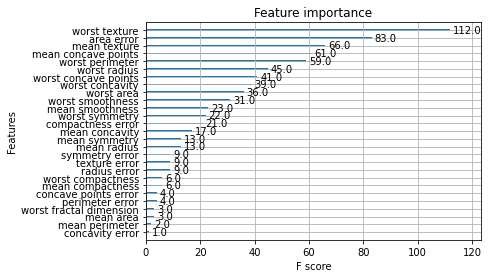

In [28]:
# plot_importance: f스코어를 기반으로 해당 피처의 중요도를 나타냄
plot_importance(xgb_model)

#### 사이킷런 래퍼 XGBoost

In [29]:
from xgboost import XGBClassifier

In [32]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [33]:
get_clf_eval(y_test, w_preds, w_preds_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, roc_auc: 0.9954


In [37]:
# 조기종료
evals = [(X_tr, y_tr),(X_val, y_val)] # 알아서 앞 튜플이 학습용, 뒤 튜플이 검증용으로 인식됨
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

# [126]	validation_0-logloss:0.01973	validation_1-logloss:0.25587

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

[130]	validation_0-logloss:0.01886	validation_1-logloss:0.25712
[131]	validation_0-logloss:0.01863	validation_1-logloss:0.25609
[132]	validation_0-logloss:0.01839	validation_1-logloss:0.25649
[133]	validation_0-logloss:0.01816	validation_1-logloss:0.25789
[134]	validation_0-logloss:0.01802	validation_1-logloss:0.25811
[135]	validation_0-logloss:0.01785	validation_1-logloss:0.25794
[136]	validation_0-logloss:0.01763	validation_1-logloss:0.25876
[137]	validation_0-logloss:0.01748	validation_1-logloss:0.25884
[138]	validation_0-logloss:0.01732	validation_1-logloss:0.25867
[139]	validation_0-logloss:0.01719	validation_1-logloss:0.25876
[140]	validation_0-logloss:0.01696	validation_1-logloss:0.25987
[141]	validation_0-logloss:0.01681	validation_1-logloss:0.25960
[142]	validation_0-logloss:0.01669	validation_1-logloss:0.25982
[143]	validation_0-logloss:0.01656	validation_1-logloss:0.25992
[144]	validation_0-logloss:0.01638	validation_1-logloss:0.26035
[145]	validation_0-logloss:0.01623	valid

In [38]:
get_clf_eval(y_test, preds, preds_proba)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, roc_auc: 0.9933


조기 중단값(early_stopping_rounds)을 너무 급격하게 줄여버리면, 성능 저하될 우려 큼

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

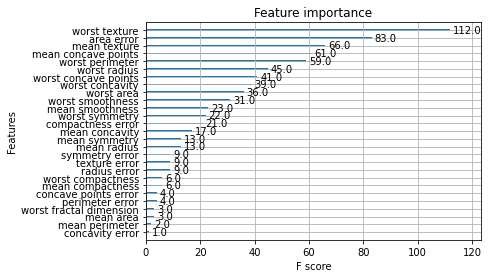

In [39]:
# plot_importance() 에 사이킷런 래퍼 클래스를 입력해도 똑같이 시각화 결과 도출해줌
plot_importance(xgb_wrapper)